### Neighborhood-based NARVAL model on QUBICC data

<a id='import_and_models_start'></a>

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import importlib
import for_preprocessing

from tensorflow.keras.models import load_model

importlib.reload(for_preprocessing)
from for_preprocessing import load_day

%config Completer.use_jedi = False  #Speeds up autocomplete

In [2]:
root_path = '/pf/b/b309170'
data_path = os.path.join(root_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/region_based/based_on_var_interpolated_data')
model_path = os.path.join(root_path,
                          'workspace_icon-ml/cloud_cover_parameterization/region_based/saved_models')
info_file = os.path.join(root_path, 
                        'workspace_icon-ml/cloud_cover_parameterization/region_based/saved_models/model_region_based_final_1.txt')

n_layers = 27 # Is also the number of NNs

*Load model*

In [3]:
models = [load_model(os.path.join(model_path, 'model_clc_all_days_final_1_%d.h5'%i)) for i in range(27)]

<a id='import_and_models_end'></a>

## Hovmöller diagrams

**First visualization method** (Third in other notebooks) <br>
Hovmöller diagram (time on x-axis with vertical layers on y-axis and NN mean clc in color) <br>
Looking at one day here.

In [151]:
path = "/pf/b/b309170/my_work/QUBICC/data_var_vertinterp/"

ls = os.listdir(os.path.join(path, 'ta')) #Temperature as an arbitrary variable
days = set()
for j in range(len(ls)):
    day = ls[j].split(sep='_')[7][:8] #Days in QUBICC
    days.add(day)

# Get one day
day = days.pop()

# Careful: The first and last days of QUBICC do not have 23 timesteps
# I think it's generally one timestep less as the region-based model looks back one timestep as well
if day == '20041101':
    timesteps_per_day = 22
else:
    timesteps_per_day = 23

if day == '20041202':
    raise ValueError('Try to load a day in November instead.')

dfs = load_day(day, n_layers, path, data_source='qubicc')

print(day) # Which day is it?

20041102


In [152]:
# In QUBICC cloud cover is in [0, 1]
for i in range(n_layers):
    dfs[i]['cl'] = 100*dfs[i]['cl']
    dfs[i]['cl_prev'] = 100*dfs[i]['cl_prev']

In [153]:
# Usually in QUBICC hc2: (TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (721, 27/31, 14826)
# Usually in NARVAL: (TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (1635, 75/31/27, 1306)

## Load data pertaining to a specific NN
n_samples_per_layer = dfs[0].shape[0]
n_features = dfs[0].shape[1] - 1

# Where's the temporal information?
# It's spaced 14826 entries apart in QUBICC (=n_samples_per_layer/(timesteps_per_day*no_of_days)):
temp_spacing = int(n_samples_per_layer/timesteps_per_day)

rand_ind = np.random.randint(dfs[20].shape[0]-temp_spacing)
assert dfs[20]['cl'][rand_ind] == dfs[20]['cl_prev'][rand_ind+temp_spacing]

dfs[1].columns

Index(['hus_i-2', 'hus_i-1', 'hus_i', 'hus_i+1', 'hus_i+2', 'clw_i-2',
       'clw_i-1', 'clw_i', 'clw_i+1', 'clw_i+2', 'cli_i-2', 'cli_i-1', 'cli_i',
       'cli_i+1', 'cli_i+2', 'ta_i-2', 'ta_i-1', 'ta_i', 'ta_i+1', 'ta_i+2',
       'pfull_i-2', 'pfull_i-1', 'pfull_i', 'pfull_i+1', 'pfull_i+2',
       'rho_i-2', 'rho_i-1', 'rho_i', 'rho_i+1', 'rho_i+2', 'zg_i-2', 'zg_i-1',
       'zg_i', 'zg_i+1', 'zg_i+2', 'fr_lake', 'cl_prev', 'cl'],
      dtype='object')

In [154]:
# Load the data into dictionaries. Can't use 3D tensors here as some features will be removed depending on the NN.
# One entry (time*hor x features matrix) in the dictionary per vertical layer
input_NN = {}
for i in range(n_layers):
    input_NN[i] = np.zeros((n_samples_per_layer, n_features))
    
data_clc = {}
for i in range(n_layers):
    data_clc[i] = np.zeros((n_samples_per_layer))
    
for i in range(n_layers):
    input_NN[i] = np.array(dfs[i])[:, :-1]
    data_clc[i] = np.array(dfs[i])[:, -1]

In [155]:
# We read the means and standard deviations from model_region_based_final_1.txt!
# I manually replaced nan's in the text-file by 1e+30 before reading the file.

means = {}
for i in range(n_layers):
    means[i] = np.zeros(n_features)
    
stds = {}
for i in range(n_layers):
    stds[i] = np.zeros(n_features)
    
layer = -1
with open(info_file, 'r') as file:
    while True:
        line = file.readline()
        # Retrieving the mean values
        if line.startswith('The mean values'):
            j = 0 # Feature entry in mean tensor
            layer += 1
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        means[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        means[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        means[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        means[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break
                    
        if line.startswith('The standard deviation values'):
            j = 0 # Feature entry in mean tensor
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        stds[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        stds[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        stds[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        stds[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break  
        # If the end of the file is reached            
        if not line:
            break

In [156]:
# Load NARVAL input_train_NN for the next cell
root_path = '/pf/b/b309170'
data_path = os.path.join(root_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/region_based/based_on_var_interpolated_data')

input_train = np.load(os.path.join(data_path, 'cloud_cover_input_train_1.npy'))
(n_train_samples, n_features) = input_train.shape

input_train_NN = {}
for i in range(n_layers):
    input_train_NN[i] = np.zeros((n_train_samples//n_layers, n_features))

for i in range(n_layers):
    start_ind_train = (n_train_samples//27)*i
    end_ind_train = (n_train_samples//27)*(i+1) 

    input_train_NN[i] = input_train[start_ind_train:end_ind_train]

In [157]:
# We remove the input features with zero variance in the TRAINING set. We compute the resulting input dimension for the NN.
for i in range(n_layers):
    vars_to_remove = []
    for j in range(n_features):
        if np.var(input_train_NN[i][:, j]) == 0 or np.isnan(np.var(input_train_NN[i][:, j])): #We reuse input_train_NN here!
            vars_to_remove.append(j)
    input_NN[i] = np.delete(input_NN[i], vars_to_remove, axis=1)    
    means[i] = np.delete(means[i], vars_to_remove)
    stds[i] = np.delete(stds[i], vars_to_remove)

In [158]:
# We standardize the input data according to model_region_based_final_1.txt
for j in range(n_layers):
    # For some reason for the two highest j the output is 'float' instead of np.float32/np.float64. 
    # This makes the data un-predictable by the tensorflow model
    if j > n_layers-3:
        input_NN[j] = ((input_NN[j] - means[j])/stds[j]).astype(np.float64)
    else:
        input_NN[j] = (input_NN[j] - means[j])/stds[j]

In [159]:
# All vertical layers from first time step
pred_clc_mat = np.zeros((timesteps_per_day, n_layers))
data_clc_mat = np.zeros((timesteps_per_day, n_layers))
for i in range(timesteps_per_day):
    for j in range(n_layers):
#         print(input_NN[j][i*14826:(i+1)*14826].shape)
        # Mean prediction for a specific time step and vertical layer
        pred_1 = models[j].predict(input_NN[j][i*temp_spacing:(i+1)*temp_spacing])
        pred_clc_mat[i,j] = np.mean(np.minimum(np.maximum(pred_1, 0), 100))   
        # Mean cloud cover for a specific time step and vertical layer
        data_clc_mat[i,j] = np.mean(data_clc[j][i*temp_spacing:(i+1)*temp_spacing])

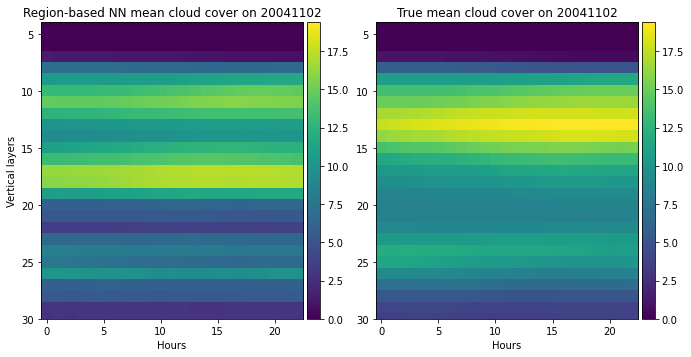

In [167]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

capped_matrix = np.zeros((timesteps_per_day, 31))
capped_matrix_data = np.zeros((timesteps_per_day, 31))
capped_matrix[:, 4:] = pred_clc_mat
capped_matrix_data[:, 4:] = data_clc_mat

# Crucial so that the colorbar will actually match both plots
vmax = np.maximum(np.max(capped_matrix), np.max(capped_matrix_data))
vmin = np.minimum(np.min(capped_matrix), np.min(capped_matrix_data))
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(11,8))
ax_2 = fig.add_subplot(122, xlabel='Hours', ylim=[30, 4], title='True mean cloud cover on %s'%day)
ims_2 = ax_2.imshow(np.transpose(capped_matrix_data), vmin=vmin, vmax=vmax)
# Colorbar axes
divider = make_axes_locatable(ax_2)
cax_2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ims_2, cax=cax_2)

ax_1 = fig.add_subplot(121, xlabel='Hours', ylim=[30, 4], ylabel='Vertical layers', 
                       title='Region-based NN mean cloud cover on %s'%day)
ims_1 = ax_1.imshow(np.transpose(capped_matrix), vmin=vmin, vmax=vmax)
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ims_1, cax=cax_1)
# fig.savefig('../figures/qubicc_offline_testing_hovmoeller.pdf')

/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


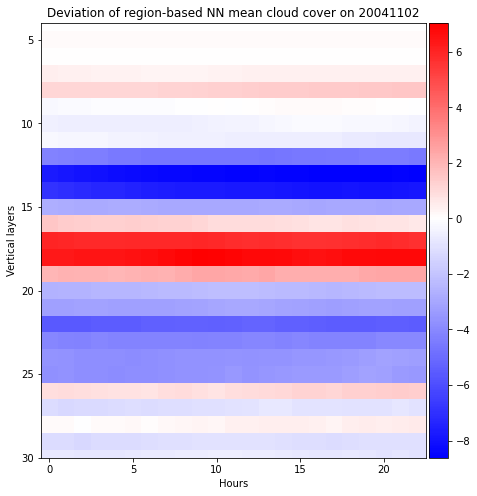

In [163]:
# Difference

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib.colors import DivergingNorm

capped_matrix = np.zeros((timesteps_per_day, 31))
capped_matrix_data = np.zeros((timesteps_per_day, 31))
capped_matrix[:, 4:] = pred_clc_mat
capped_matrix_data[:, 4:] = data_clc_mat
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(8,8))
# ax_2 = fig.add_subplot(122, xlabel='Hours', ylim=[30, 4], title='True mean cloud cover (One day)')
# ims_2 = ax_2.imshow(np.transpose(capped_matrix_data))
# # Colorbar axes
# divider = make_axes_locatable(ax_2)
# cax_2 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(ims_2, cax=cax_2)

ax_1 = fig.add_subplot(111, xlabel='Hours', ylim=[30, 4], ylabel='Vertical layers', 
                       title='Deviation of region-based NN mean cloud cover on %s'%day)
ims_1 = ax_1.imshow(np.transpose(capped_matrix - capped_matrix_data), norm=DivergingNorm(0), cmap='bwr')
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ims_1, cax=cax_1)
# fig.savefig('../figures/qubicc_offline_testing_hovmoeller_diff.pdf')

## Predictions on random samples

**Second visualization method** (First in other notebooks) <br>
Samples on x-axis and cloud cover on y-axis

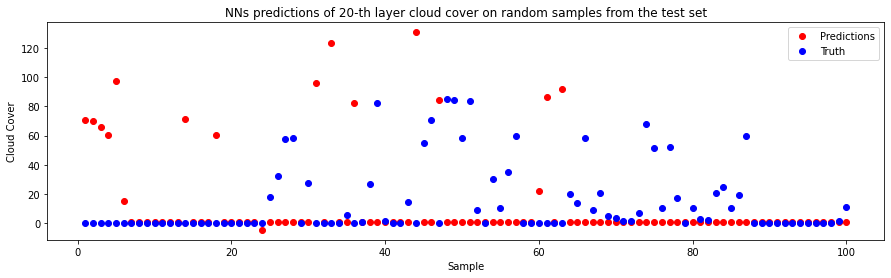

In [171]:
no_samples = 100
layer = 20
clc_pred = models[layer].predict(input_NN[layer][:no_samples])
clc_true = data_clc[layer][:no_samples]
a = np.linspace(1, no_samples, no_samples)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111, title='NNs predictions of %d-th layer cloud cover on random samples from the test set'%layer, 
                     xlabel='Sample', ylabel='Cloud Cover')
ax.plot(a, clc_pred, 'ro')
ax.plot(a, clc_true, 'bo')
ax.legend(['Predictions', 'Truth'])
# fig.savefig('../figures/qubicc_offline_testing_predictions_random_samples.pdf')

## Mean cloud cover per vertical layer

**Thir visualization method** (Second in other notebooks) <br>
Mean profile of Cloud Cover on x-axis with Vertical Layer on y-axis. This time I can use the test set.

In [172]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
clc_pred_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(data_clc[i]))
    # Predicted cloud cover means
    pred_adj = np.minimum(np.maximum(models[i].predict(input_NN[i]), 0), 100)
    clc_pred_mean.append(np.mean(pred_adj, axis=0, dtype=np.float64))

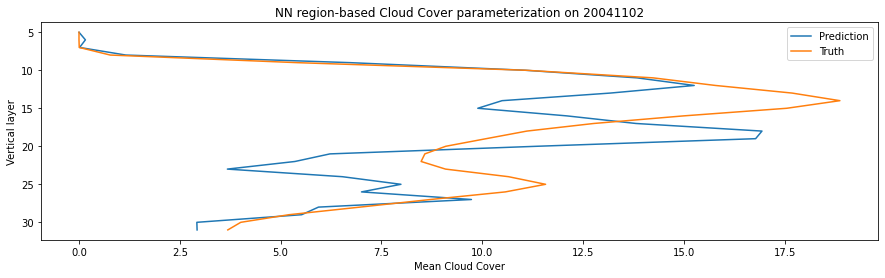

In [173]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN region-based Cloud Cover parameterization on %s'%day)
ax_1.plot(clc_pred_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_one_day.pdf')

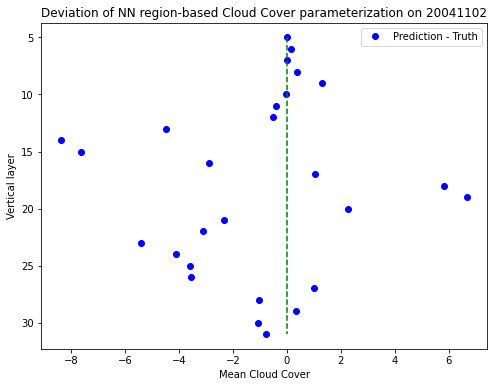

In [174]:
# Plotting the difference
fig = plt.figure(figsize=(8,6))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='Deviation of NN region-based Cloud Cover parameterization on %s'%day)
ax_1.plot(np.squeeze(np.array(clc_pred_mean)) - np.array(clc_data_mean), a, 'bo')
ax_1.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_1.legend(['Prediction - Truth'])
# fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_diff_one_day.pdf')

### Load Nov, 20s

For Nov, 20s (all days is too costly)

<a id='load_data_start'></a>

In [4]:
path = "/pf/b/b309170/my_work/QUBICC/data_var_vertinterp/"

timesteps_per_day = 23

# Load November 20s
days = ['20041120', '20041121', '20041122', '20041123', '20041124', '20041125', '20041126', '20041127',
       '20041128', '20041129']

no_of_days = len(days)

In [5]:
# Store all days in an array of dataframes (each row is a training sample for the NN)
dfs = load_day(days.pop(), n_layers, path, data_source='qubicc')
while len(days) > 0: #while len(days) > 0 to load all days
    tmp = load_day(days.pop(), n_layers, path, data_source='qubicc')
    for i in range(n_layers):
        dfs[i] = dfs[i].append(tmp[i], ignore_index=True)

In [6]:
# In QUBICC cloud cover is in [0, 1]
for i in range(n_layers):
    dfs[i]['cl'] = 100*dfs[i]['cl']
    dfs[i]['cl_prev'] = 100*dfs[i]['cl_prev']

In [7]:
# Usually in QUBICC hc2: (TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (721, 27/31, 14826)
# Usually in NARVAL: (TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (1635, 75/31/27, 1306)

TIME_STEPS = timesteps_per_day*no_of_days
HORIZ_FIELDS = len(dfs[0]['cl'])//TIME_STEPS

## Load data pertaining to a specific NN
n_samples_per_layer = dfs[0].shape[0]
n_features = dfs[0].shape[1] - 1

# Where's the temporal information?
# It's spaced 14826 entries apart in QUBICC (=n_samples_per_layer/(timesteps_per_day*no_of_days)):
temp_spacing = int(n_samples_per_layer/TIME_STEPS)

rand_ind = np.random.randint(dfs[20].shape[0]-temp_spacing)
assert dfs[20]['cl'][rand_ind] == dfs[20]['cl_prev'][rand_ind+temp_spacing]

dfs[1].columns

Index(['hus_i-2', 'hus_i-1', 'hus_i', 'hus_i+1', 'hus_i+2', 'clw_i-2',
       'clw_i-1', 'clw_i', 'clw_i+1', 'clw_i+2', 'cli_i-2', 'cli_i-1', 'cli_i',
       'cli_i+1', 'cli_i+2', 'ta_i-2', 'ta_i-1', 'ta_i', 'ta_i+1', 'ta_i+2',
       'pfull_i-2', 'pfull_i-1', 'pfull_i', 'pfull_i+1', 'pfull_i+2',
       'rho_i-2', 'rho_i-1', 'rho_i', 'rho_i+1', 'rho_i+2', 'zg_i-2', 'zg_i-1',
       'zg_i', 'zg_i+1', 'zg_i+2', 'fr_lake', 'cl_prev', 'cl'],
      dtype='object')

<a id='load_data_stop'></a>

In [30]:
# Load the data into dictionaries. Can't use 3D tensors here as some features will be removed depending on the NN.
# One entry (time*hor x features matrix) in the dictionary per vertical layer
input_NN = {}
for i in range(n_layers):
    input_NN[i] = np.zeros((n_samples_per_layer, n_features))
    
data_clc = {}
for i in range(n_layers):
    data_clc[i] = np.zeros((n_samples_per_layer))
    
for i in range(n_layers):
    input_NN[i] = np.array(dfs[i])[:, :-1]
    data_clc[i] = np.array(dfs[i])[:, -1]

In [31]:
# We read the means and standard deviations from model_region_based_final_1.txt!
# I manually replaced nan's in the text-file by 1e+30 before reading the file.

means = {}
for i in range(n_layers):
    means[i] = np.zeros(n_features)
    
stds = {}
for i in range(n_layers):
    stds[i] = np.zeros(n_features)
    
layer = -1
with open(info_file, 'r') as file:
    while True:
        line = file.readline()
        # Retrieving the mean values
        if line.startswith('The mean values'):
            j = 0 # Feature entry in mean tensor
            layer += 1
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        means[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        means[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        means[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        means[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break
                    
        if line.startswith('The standard deviation values'):
            j = 0 # Feature entry in mean tensor
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        stds[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        stds[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        stds[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        stds[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break  
        # If the end of the file is reached            
        if not line:
            break

In [32]:
# Load NARVAL input_train_NN for the next cell
root_path = '/pf/b/b309170'
data_path = os.path.join(root_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/region_based/based_on_var_interpolated_data')

input_train = np.load(os.path.join(data_path, 'cloud_cover_input_train_1.npy'))
(n_train_samples, n_features) = input_train.shape

input_train_NN = {}
for i in range(n_layers):
    input_train_NN[i] = np.zeros((n_train_samples//n_layers, n_features))

for i in range(n_layers):
    start_ind_train = (n_train_samples//27)*i
    end_ind_train = (n_train_samples//27)*(i+1) 

    input_train_NN[i] = input_train[start_ind_train:end_ind_train]

In [33]:
# We remove the input features with zero variance in the TRAINING set. We compute the resulting input dimension for the NN.
for i in range(n_layers):
    vars_to_remove = []
    for j in range(n_features):
        if np.var(input_train_NN[i][:, j]) == 0 or np.isnan(np.var(input_train_NN[i][:, j])): #We reuse input_train_NN here!
            vars_to_remove.append(j)
    input_NN[i] = np.delete(input_NN[i], vars_to_remove, axis=1)    
    means[i] = np.delete(means[i], vars_to_remove)
    stds[i] = np.delete(stds[i], vars_to_remove)

In [34]:
# We standardize the input data according to model_region_based_final_1.txt
for j in range(n_layers):
    # For some reason for the two highest j the output is 'float' instead of np.float32/np.float64. 
    # This makes the data un-predictable by the tensorflow model
    if j > n_layers-3:
        input_NN[j] = ((input_NN[j] - means[j])/stds[j]).astype(np.float64)
    else:
        input_NN[j] = (input_NN[j] - means[j])/stds[j]

In [35]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
clc_pred_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(data_clc[i]))
    # Predicted cloud cover means
    pred_adj = np.minimum(np.maximum(models[i].predict(input_NN[i]), 0), 100)
    clc_pred_mean.append(np.mean(pred_adj, axis=0, dtype=np.float64))

<a id='load_data_end'></a>

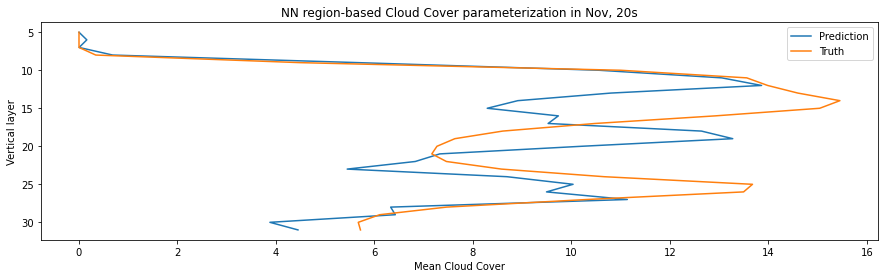

In [16]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN region-based Cloud Cover parameterization in Nov, 20s')
ax_1.plot(clc_pred_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs.pdf')

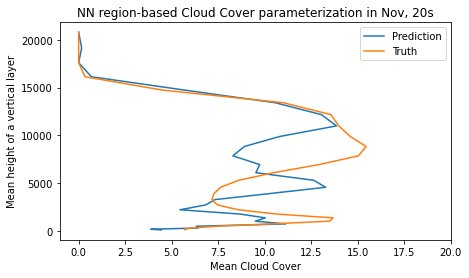

In [28]:
# With height vertical axis
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

fig = plt.figure(figsize=(7,4))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Mean height of a vertical layer', 
                       title='NN region-based Cloud Cover parameterization in Nov, 20s', xlim=[-1, 20])
ax_1.plot(clc_pred_mean, zg_mean)
ax_1.plot(clc_data_mean, zg_mean)
# plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_height_vert_axis.pdf')

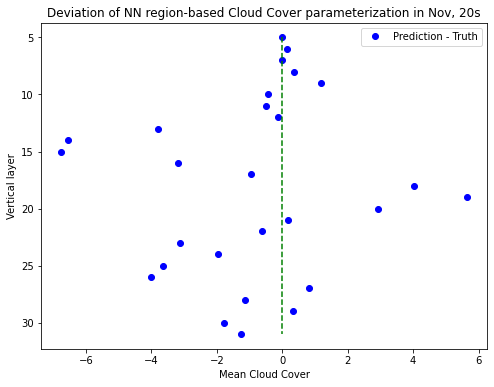

In [16]:
# Plotting the difference
fig = plt.figure(figsize=(8,6))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='Deviation of NN region-based Cloud Cover parameterization in Nov, 20s')
ax_1.plot(np.squeeze(np.array(clc_pred_mean)) - np.array(clc_data_mean), a, 'bo')
ax_1.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_1.legend(['Prediction - Truth'])
# fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_diff.pdf')

## In NARVAL region only

**Fourth visualization method** <br>
Interpret NN parameterizations on QUBICC data in NARVAL region

Run cells 1-3 ([import_and_models_start](#import_and_models_start) to [import_and_models_end](#import_and_models_end)). <br>
Then 'Load Nov,20s', cells 1-4 ([load_data_start](#load_data_start) to [load_data_stop](#load_data_stop))

In [8]:
# We reshape dfs[i] back to array of 2D-dicts. 
dicts_2d = []
for i in range(n_layers):
    dicts_2d.append({})
    
for i in range(n_layers):
    for key in dfs[i].keys():
        dicts_2d[i][key] = np.reshape(dfs[i][key].to_numpy(), (TIME_STEPS, HORIZ_FIELDS))

for key in dicts_2d[0].keys():
    print(dicts_2d[0][key].shape)

(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)
(230, 14826)


We need to:
1) Reinsert nans that arose through overlapping topography during vertical interpolation into the QUBICC data
2) Set fields from outside the NARVAL region to nan
3) We select the fields where the lowermost levels are not nan

Step 1): So that we have 20480 horizontal fields and can compare that directly to the R02B04-grid. <br>
Note that data_dict.shape[2] != data_dict_new.shape[2]

Step 3) should leave us with only those grid columns that are in the NARVAL region and that have been coarse-grained without producing nans in QUBICC 

*1. Overlapping nans*

In [9]:
path = '/pf/b/b309170/my_work/QUBICC/data_var_vertinterp/cli'
file_name = 'int_var_hc2_02_p1m_cli_ml_20041112T200000Z_R02B04.nc'

In [10]:
DS = xr.open_dataset(os.path.join(path, file_name))
da_cli = DS.cli.values
overlap_nans = np.isnan(da_cli[0,30,:])
overlap_nans.shape

(20480,)

In [11]:
# Create new data_dicts with correct dimensionality
dicts_new = []
for i in range(n_layers):
    dicts_new.append({})
    
for i in range(n_layers):
    for key in dicts_2d[i].keys():
        dicts_new[i][key] = np.zeros((TIME_STEPS, len(overlap_nans)))

In [12]:
# ov_f is a temporary array that is adjusted depending on the key, time step and vertical layer
ov_f = np.array(overlap_nans, dtype=float)
ov_f[np.where(ov_f == 1)] = np.nan # Every True in overlap_nans will be a nan
ov_f_copy = ov_f.copy() # Need this otherwise ov_f == 0 will never be true anymore when beginning the loop

for i in range(TIME_STEPS):
    for j in range(n_layers):
        for key in dicts_2d[j].keys():
            ov_f_copy[np.where(ov_f == 0)] = dicts_2d[j][key][i,:] 
            dicts_new[j][key][i,:] = ov_f_copy    

In [13]:
for keys in dicts_new[0].keys():
    print(dicts_new[0][keys].shape)

(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)
(230, 20480)


*2. Which of these entries are from the NARVAL region?*

In [14]:
# path = '/pf/b/b309170/my_work/NARVAL/data/temp'
# file_name = 'temp_R02B04_NARVALI_2013121600_fg_DOM01_0012.nc'

In [15]:
# DS = xr.open_dataset(os.path.join(path, file_name))
# da_temp = DS.temp.values
# narval_nans = np.isnan(da_temp[0,0,:])
# narval_nans.shape

In [16]:
# # Keep only the narval region
# for key in dicts_new[0].keys():
#     for i in range(TIME_STEPS):
#         for k in range(20480): # Horizontal fields
#             if narval_nans[k]:
#                 for j in range(n_layers):
#                     dicts_new[j][key][i,k] = np.nan 

In [18]:
# Entire tropical zone or NARVAL region?

region = 'tropical_zone' # 'NARVAL_region' or 'tropical_zone'

if region == 'NARVAL_region':
    # Narval region: 68W-15E, 10S-20N
    lat_lower_bound = -10/90*np.pi/2
    lat_upper_bound = 20/90*np.pi/2
    lon_lower_bound = -68/180*np.pi
    lon_upper_bound = 15/180*np.pi
elif region == 'tropical_zone':
    # Tropical zone: 23.4365S-23.4365N (Narval region: 68W-15E, 10S-20N)
    lat_lower_bound = -23.4365/90*np.pi/2
    lat_upper_bound = 23.4365/90*np.pi/2
    lon_lower_bound = -np.pi #Basically unbounded
    lon_upper_bound = np.pi #Basically unbounded

In [24]:
#Load native grid
qubicc_r02b04_path = '/pf/b/b309170/my_work/QUBICC/grids/icon_grid_0013_R02B04_G.nc'
qubicc_r02b04 = xr.open_dataset(qubicc_r02b04_path)

qubicc_lat = qubicc_r02b04.lat_cell_centre.values
qubicc_lon = qubicc_r02b04.lon_cell_centre.values

In [25]:
# Keep only the narval region
for key in dicts_new[0].keys():
    for i in range(TIME_STEPS):
        for k in range(20480): # Horizontal fields
            # If k-th entry of the qubicc r02b04 grid is in narval region
            if not (lat_lower_bound <= qubicc_lat[k] <= lat_upper_bound and lon_lower_bound <= qubicc_lon[k] <= lon_upper_bound):
                for j in range(n_layers):
                    dicts_new[j][key][i,k] = np.nan

*3. We select the fields where the lowermost levels are not nan*

In [26]:
not_nan = ~np.isnan(dicts_new[n_layers-1]['hus_i'][0,:])

In [27]:
# Create new data_dict with correct dimensionality
dicts_selected_fields = []
for i in range(n_layers):
    dicts_selected_fields.append({})
    
for i in range(n_layers):
    for key in dicts_new[0].keys():
        dicts_selected_fields[i][key] = dicts_new[i][key][:,not_nan]

In [28]:
# Update the number of horizontal fields
HORIZ_FIELDS = np.sum(not_nan)
HORIZ_FIELDS

5924

Now we can reshape back:

In [29]:
#Reshaping into 1D-arrays and converting dict into DataFrame-objects (the following is based on Aurelien Geron)
for i in range(n_layers):
    for key in dicts_selected_fields[i].keys():
        dicts_selected_fields[i][key] = np.reshape(dicts_selected_fields[i][key], -1) 

dfs = []
for i in range(n_layers):
    dfs.append(pd.DataFrame.from_dict(dicts_selected_fields[i]))
    
dfs[0].head() 

,hus_i-2,hus_i-1,hus_i,hus_i+1,hus_i+2,clw_i-2,clw_i-1,clw_i,clw_i+1,clw_i+2,...,rho_i+1,rho_i+2,zg_i-2,zg_i-1,zg_i,zg_i+1,zg_i+2,fr_lake,cl_prev,cl
0,0.000002,0.000002,0.000002,0.000003,0.000003,NaN,NaN,0.0,0.0,0.0,...,0.108811,0.144100,24305.364395,22500.869849,20784.627061,19153.337334,17603.957868,0.0,0.0,0.0
1,0.000002,0.000002,0.000002,0.000003,0.000003,NaN,NaN,0.0,0.0,0.0,...,0.108626,0.144374,24305.364395,22500.869849,20784.627061,19153.337334,17603.957868,0.0,0.0,0.0
2,0.000002,0.000002,0.000002,0.000003,0.000003,NaN,NaN,0.0,0.0,0.0,...,0.108894,0.144081,24305.364395,22500.869849,20784.627061,19153.337334,17603.957868,0.0,0.0,0.0
3,0.000002,0.000002,0.000002,0.000003,0.000003,NaN,NaN,0.0,0.0,0.0,...,0.108726,0.144078,24305.364395,22500.869849,20784.627061,19153.337334,17603.957868,0.0,0.0,0.0
4,0.000002,0.000002,0.000002,0.000003,0.000003,NaN,NaN,0.0,0.0,0.0,...,0.108142,0.144658,24305.364395,22500.869849,20784.627061,19153.337334,17603.957868,0.0,0.0,0.0


Run 'Load Nov,20s', cells 5-10 ([load_data_stop](#load_data_stop) to [load_data_end](#load_data_end))

Plotting:

In [27]:
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

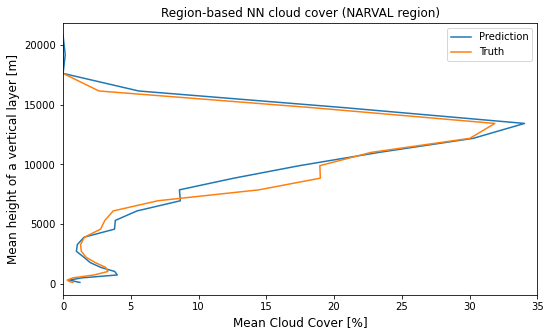

In [38]:
fig = plt.figure(figsize=(8.5,5))
# For model
ax_1 = fig.add_subplot(111, title='Region-based NN cloud cover', xlim=[0, 35])
ax_1.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_1.set_ylabel('Mean height of a vertical layer [m]', fontsize = 12)
ax_1.plot(clc_pred_mean, zg_mean)
ax_1.plot(clc_data_mean, zg_mean)
# plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_%s_nov_20s.pdf'%region)

In [48]:
clc_pred_mean_arr = np.zeros(len(clc_pred_mean))
for i in range(len(clc_pred_mean)):
    clc_pred_mean_arr[i] = clc_pred_mean[i][0]
    
print(region)
print(clc_data_mean)
print(list(clc_pred_mean_arr))

tropical_zone
[4.2935238399908094e-08, 1.1914276476657218e-05, 0.0008939737262109005, 0.7020128221126258, 9.091525735700335, 20.81475938128697, 21.31802893532254, 16.313615893339033, 12.798702209599478, 11.932855701684524, 9.265571350409363, 4.883454743895594, 2.7087740136576133, 2.1619683160431524, 2.0852139383213335, 1.4427645848193897, 1.215819161241408, 1.3458153730998983, 1.6756870048216315, 2.1837602112881256, 2.801896101713993, 2.953559938933354, 1.880843743696284, 0.7451384378074163, 0.38252501357259794, 0.31945151917096953, 0.33999688301837905]
[7.619988173246384e-05, 0.15881937742233276, 0.002941658322903258, 1.5151516676304313, 10.483777231035232, 22.525944991782275, 21.634003338133482, 16.346796475854067, 11.170464759780556, 7.993921173705163, 5.747103087295156, 6.43852628019322, 3.853038434502075, 2.5050370864618916, 2.5237031983164884, 1.3515963547327863, 1.0189016780760831, 1.059368684255583, 1.497673126053628, 1.8626313189573755, 2.4341497640965017, 3.514885723732522, 3

Was for the NARVAL region:

In [41]:
np.array(clc_data_mean)

array([0.00000000e+00, 3.30306970e-06, 9.46747280e-04, 2.64885616e+00,
       1.83728487e+01, 3.18615986e+01, 3.00125018e+01, 2.27153213e+01,
       1.89486957e+01, 1.89850742e+01, 1.44542253e+01, 6.99331287e+00,
       3.69445919e+00, 3.08537445e+00, 2.76508943e+00, 1.57831191e+00,
       1.28971722e+00, 1.34559671e+00, 1.69293853e+00, 2.38279372e+00,
       3.14337315e+00, 3.30950159e+00, 2.27792721e+00, 7.35043574e-01,
       3.01662618e-01, 4.91557466e-01, 7.28613527e-01])

In [39]:
clc_pred_mean

[array([7.619988e-05], dtype=float32),
 array([0.15881942], dtype=float32),
 array([0.00255885], dtype=float32),
 array([5.5808067], dtype=float32),
 array([20.747732], dtype=float32),
 array([34.05206], dtype=float32),
 array([30.26281], dtype=float32),
 array([23.295046], dtype=float32),
 array([17.434507], dtype=float32),
 array([12.614503], dtype=float32),
 array([8.586495], dtype=float32),
 array([8.6529255], dtype=float32),
 array([5.4503183], dtype=float32),
 array([3.855462], dtype=float32),
 array([3.7971802], dtype=float32),
 array([1.5509791], dtype=float32),
 array([1.0533612], dtype=float32),
 array([0.98050606], dtype=float32),
 array([1.5358433], dtype=float32),
 array([2.0092373], dtype=float32),
 array([2.7812295], dtype=float32),
 array([3.814342], dtype=float32),
 array([4.0018153], dtype=float32),
 array([1.4096664], dtype=float32),
 array([0.46410173], dtype=float32),
 array([0.9478781], dtype=float32),
 array([1.2404197], dtype=float32)]